# Influence of COSMO-CLM grid resolution on simulated precipitation

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cf

# plot settings
sns.set_theme(style="darkgrid", context="notebook")
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.dpi"] = 100

# map projection
# map projection
# grid_mapping = rotated_pole
# grid_mapping_name = rotated_latitude_longitude
# long_name = "coordinates of the rotated North Pole"
# grid_north_pole_latitude = 35.f
# grid_north_pole_longitude = -168.f
proj = ccrs.RotatedPole(pole_latitude=35, pole_longitude=-168)
trans = ccrs.PlateCarree()

# parameters
res = ["02", "05", "1"]

### General remarks

- ICON hat nur passende boundary files für Gitterstruktur `europa00625` (und damit nur die entsprechende Auflösung möglich) -> deshalb COSMO
- Die Simulationen wurden für drei verschiedene Gitterauflösungen (0,2°, 0,5°, 1°) durchgeführt, jeweils über Europa und mit zehn Bodenlevels bis zu einer Bodentiefe von 11,5m
- Die Anfangs- & Randbedingungen wurden aus ERA-Interim (weil neuer als ERA-40) gebastelt, diese Reanalyse hat eine Auflösung von 0,75° (~83km)
- Die Ränder (mit Artefakten durch Interpolation) können nur mit `sellonlatbox` abgeschnitten werden, da die Gitter mit den verschiedenen Auflösungen nicht exakt die gleiche Region abdecken
- Mittelwert statt Summe verwenden, da die Gesamtanzahl der Gitterboxen für jede Simulation unterschiedlich ist
- $\frac{\mathrm{kg}}{\mathrm{m^2}}$ entspricht einer Regenhöhe von $1\mathrm{mm}$, daher kann die tägliche Niederschlagsmenge ganz einfach in $\frac{\mathrm{mm}}{\mathrm{day}}$ umgerechnet werden (Faktor 1)

### Spatial domain

Mean of daily precipitation sum during simulation period

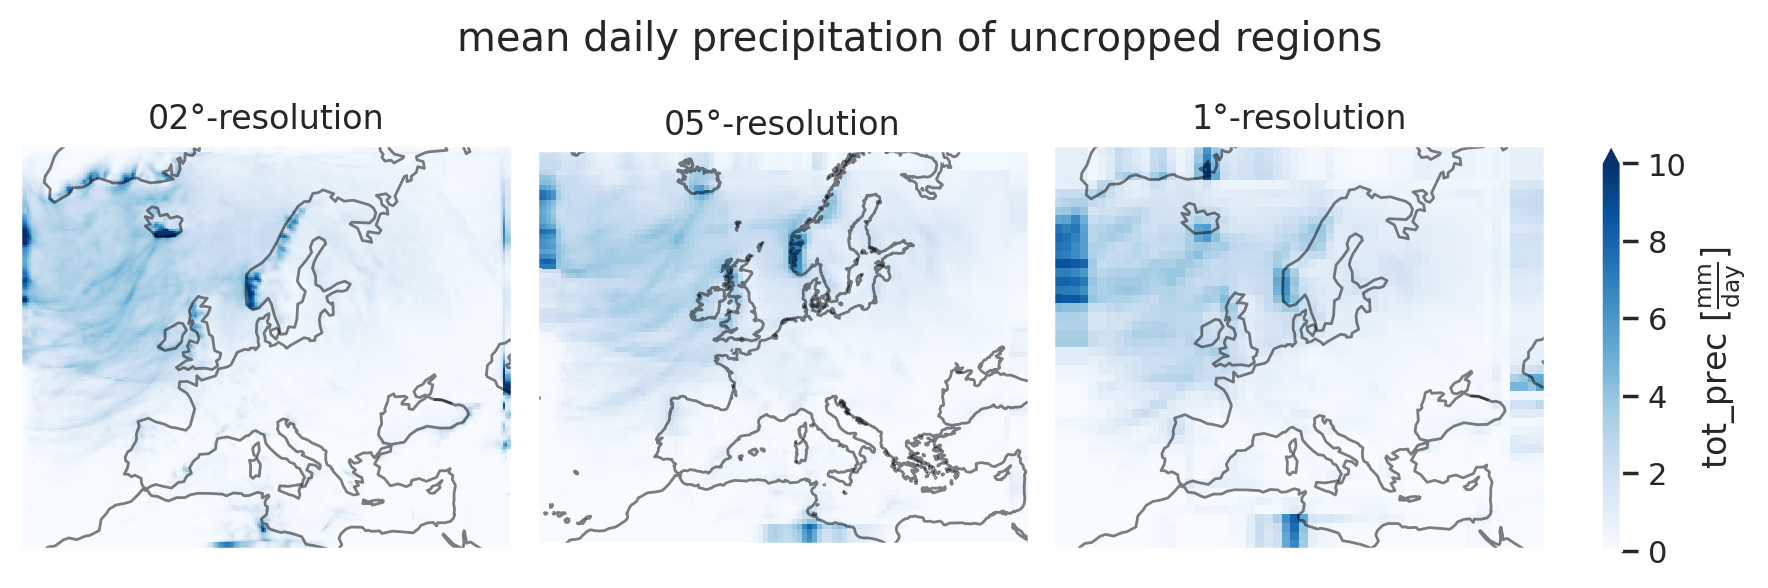

In [2]:
# import data
lon = {}
lat = {}
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_nocrop_timmean.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    totprec[r] = f.variables["tot_prec"][0,:,:]
    f.close()

# plotting
fig, axs = plt.subplots(1, 3, figsize=(12,8), gridspec_kw=dict(wspace=0.05), subplot_kw=dict(projection = proj))

for i, r in enumerate(res):
    cm = axs[i].pcolormesh(lon[r], lat[r], totprec[r], transform=trans, shading="nearest", cmap="Blues", vmin=0, vmax=10)
    axs[i].coastlines(alpha=0.5)
    #ax.gridlines(draw_labels=True)
    axs[i].set_title(f"{r}°-resolution")
    
cb = fig.colorbar(cm, extend="max", shrink=0.33, pad=0.03, ax=axs.tolist())
cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")    
fig.suptitle("mean daily precipitation of uncropped regions", y=0.7)
plt.show()

- Das Zielgebiet der 0,5°-Simulation weicht vom Rest ab, warum?
- "Falsche" Werte an den Rändern
- Außerdem ist beim Mittelwert zu beachten:
`cdo fldmean (Warning): Grid cell bounds not available, using constant grid cell area weights!`

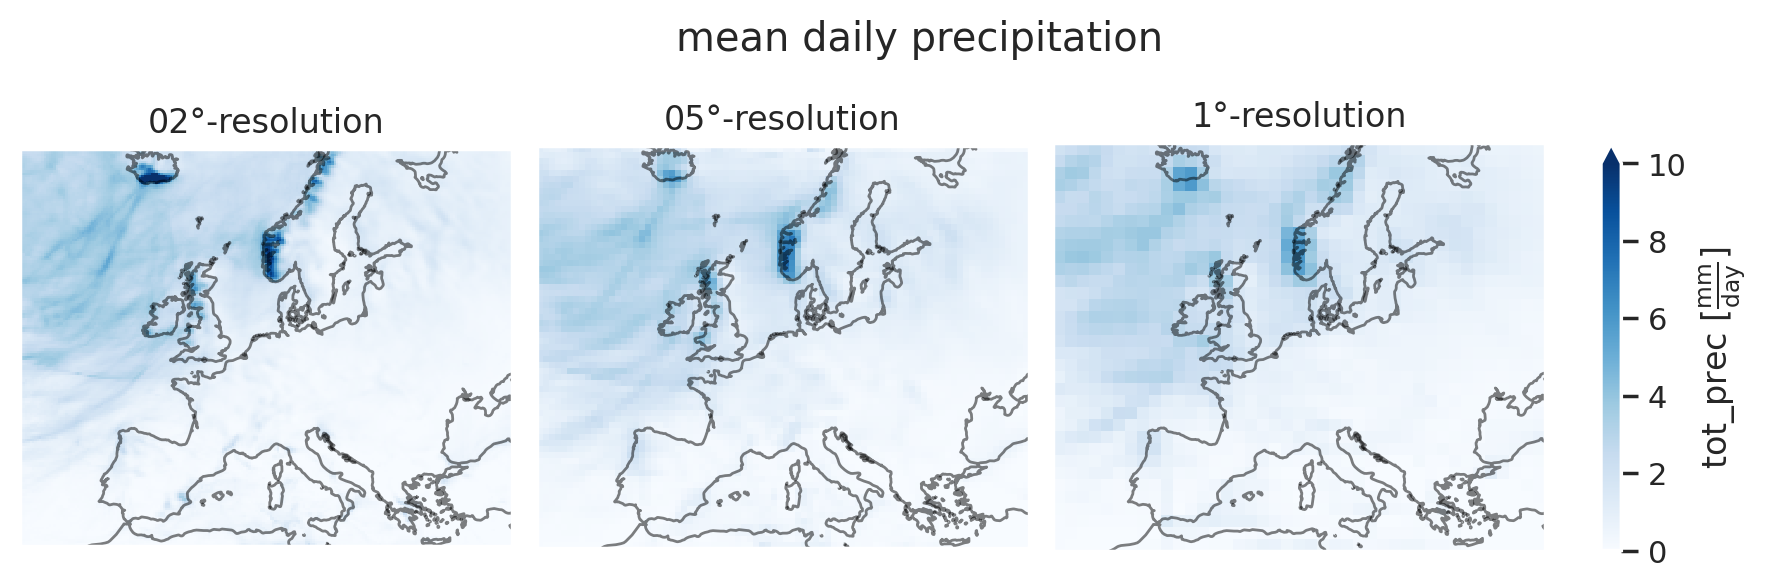

In [29]:
# import data
lon = {}
lat = {}
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_timmean.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    totprec[r] = f.variables["tot_prec"][0,:,:]
    f.close()

# plotting
fig, axs = plt.subplots(1, 3, figsize=(12,8), gridspec_kw=dict(wspace=0.05), subplot_kw=dict(projection = proj))

for i, r in enumerate(res):
    cm = axs[i].pcolormesh(lon[r], lat[r], totprec[r], transform=trans, shading="nearest", cmap="Blues", vmin=0, vmax=10)
    axs[i].coastlines(alpha=0.5)
    #ax.gridlines(draw_labels=True)
    axs[i].set_title(f"{r}°-resolution")
    
cb = fig.colorbar(cm, extend="max", shrink=0.33, pad=0.03, ax=axs.tolist())
cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")    
fig.suptitle("mean daily precipitation", y=0.7)
plt.show()

- Mehr Niederschlag bei höherer Auflösung

### Temporal domain

Mean of daily precipitation sum within "adjusted" region

In [4]:
# RefTime =  1990-01-01 00:00:00  Units = seconds  Calendar = proleptic_gregorian
def convTime(tlist):
    tt = []
    for t in tlist:
        tt.append(dt.date(1990, 1, 1) + dt.timedelta(seconds=t))
    return tt

In [5]:
# import data
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_fldmean.nc")
    time = f.variables["time"][:]
    totprec[r] = f.variables["tot_prec"][:,0,0]
    f.close()

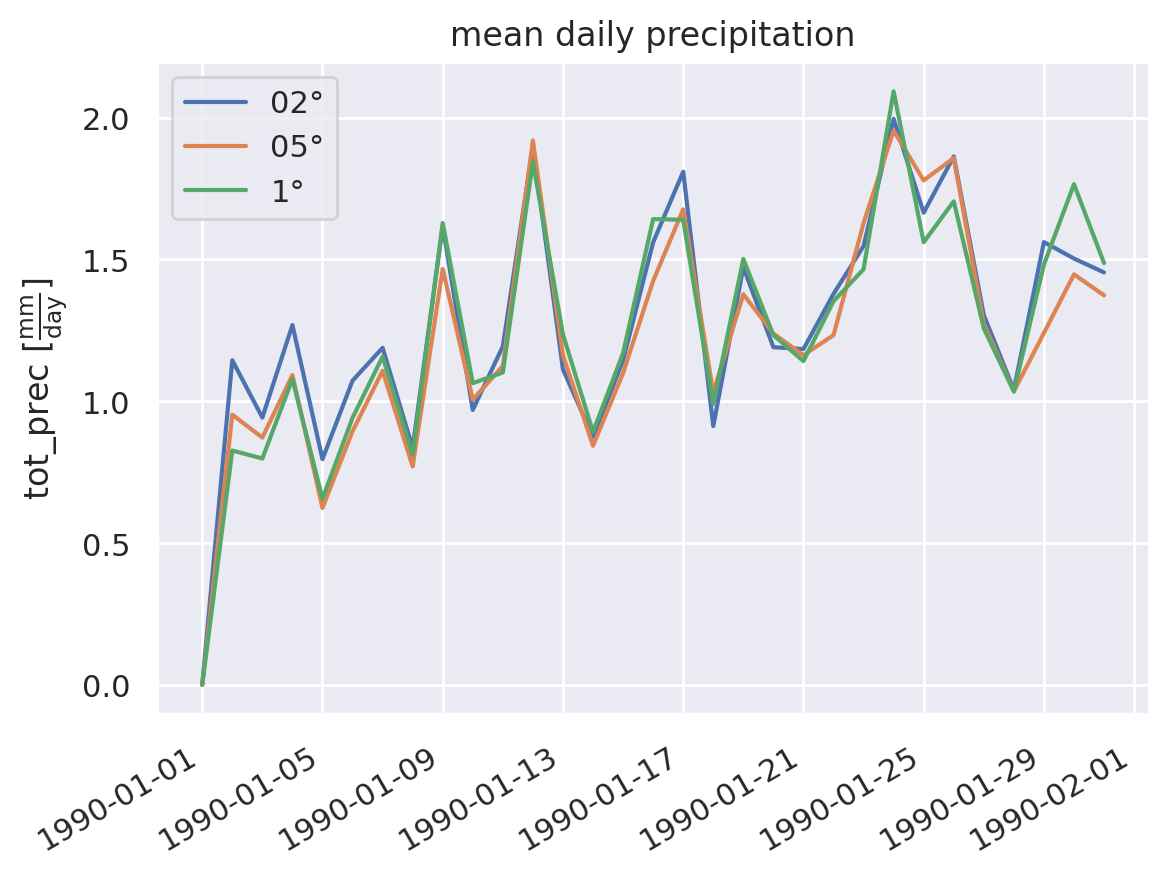

In [6]:
# plotting
fig, ax = plt.subplots()

for r in res:
    ax.plot(convTime(time), totprec[r], label=f"{r}°")
    
ax.legend()
ax.set_title("mean daily precipitation")
ax.set_ylabel(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")
fig.autofmt_xdate()

- lieber als bar plot?
- Trend zwischen Auflösungen gleich, aber absolute Werte unterschiedlich
- Erster Tag ist zum Start der Simulation, also noch kein Niederschlag
- Picke Tage mit viel Niederschlag heraus

### Hovmöller diagram

In [7]:
# import data
rlon = {}
totprec_meri = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg.nc")
    time = convTime(f.variables["time"][:])
    rlon[r] = f.variables["rlon"][:]
    totprec = f.variables["tot_prec"][:]
    # calculate meridional mean (in rotated coordinates)
    totprec_meri[r] = np.mean(totprec, axis=1)
    f.close()

In [8]:
np.shape(totprec_meri[res[0]])

(31, 207)

In [9]:
np.shape(rlon[res[0]])

(207,)

In [10]:
np.shape(time)

(31,)

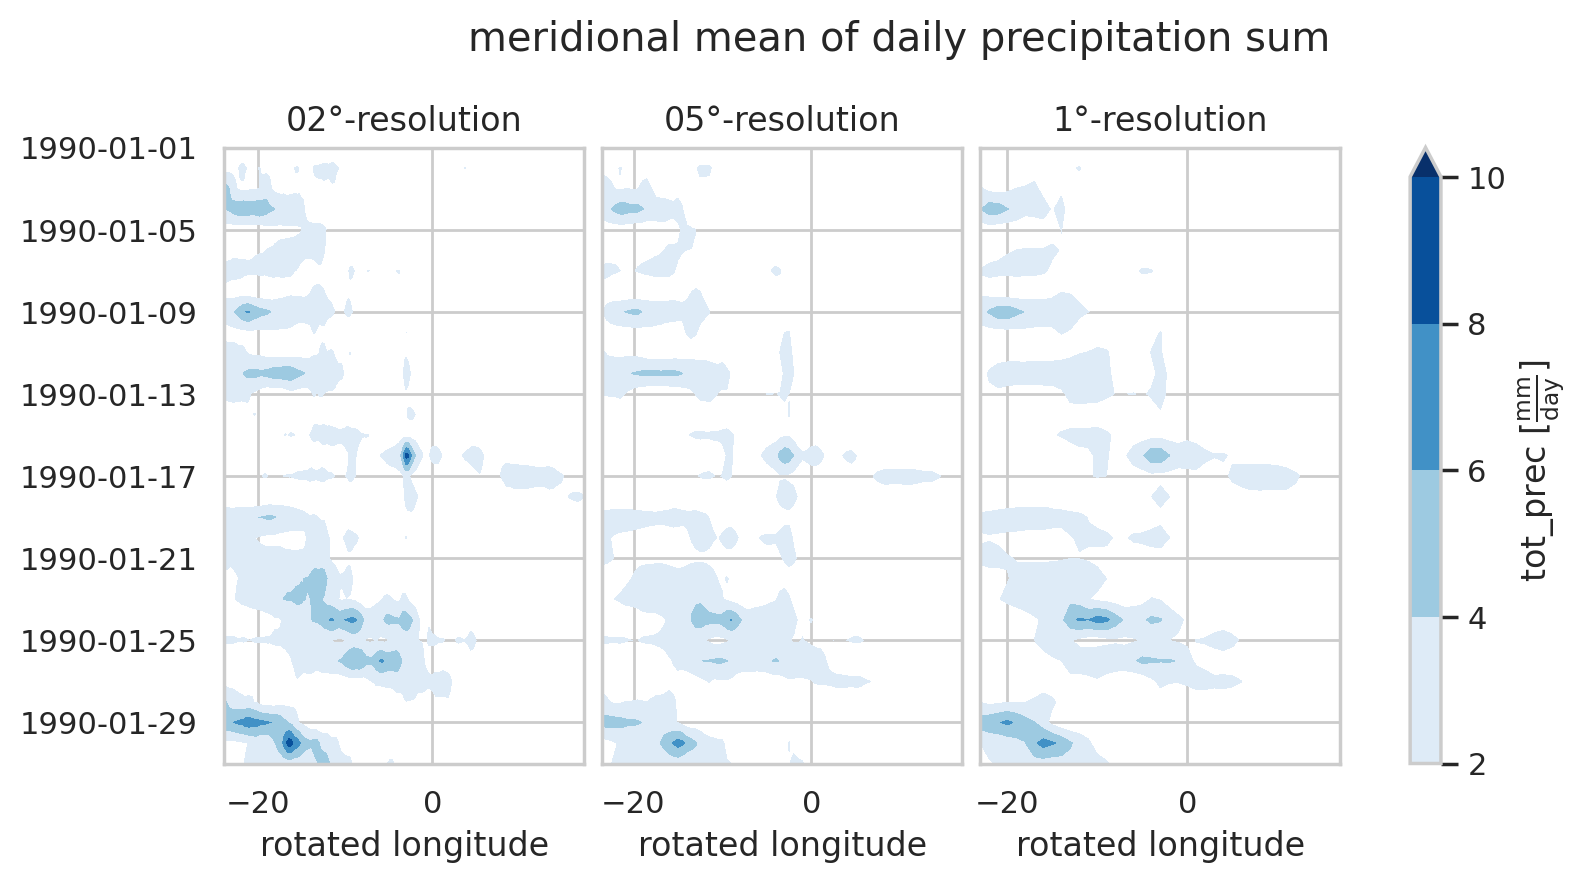

In [30]:
# plotting (temporarily change the rc parameter values)
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1, 3, figsize=(9,4), sharey=True, gridspec_kw=dict(wspace=0.05))

    for i, r in enumerate(res):
        xrlon, ytime = np.meshgrid(rlon[r], time)
        cf = axs[i].contourf(xrlon, ytime, totprec_meri[r], cmap="Blues", levels=np.linspace(2, 10, 5), extend="max")
        axs[i].invert_yaxis()
        axs[i].set_xlabel("rotated longitude")
        axs[i].set_title(f"{r}°-resolution")
    
    cb = fig.colorbar(cf, extend="max", ax=axs.tolist())
    cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")    
    fig.suptitle("meridional mean of daily precipitation sum", y=1.04)
    plt.show()

- "hereinziehender" Regen aus boundary files geht verloren in Simulation
- vorherrschende Westströmung deutlich zu erkennen
- suche Ereignisse mit viel Regen raus und plotte Wetterkarte (?)